## Import the libraries

In [ ]:

import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.metrics import binary_crossentropy
from keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
# from keras.utils import np_utils
from keras import backend as K
from keras import metrics
from keras.layers import Lambda
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from keras import layers
import os
import random
import cv2
from sklearn.model_selection import train_test_split


## Load the data

In [ ]:
!wget https://mmlab.ie.cuhk.edu.hk/archive/cufsf/files/original_sketch.zip
!unzip original_sketch.zip

--2024-02-03 07:56:33--  https://mmlab.ie.cuhk.edu.hk/archive/cufsf/files/original_sketch.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.16
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85755238 (82M) [application/zip]
Saving to: ‘original_sketch.zip’

original_sketch.zip 100%[===================>]  81.78M  5.50MB/s    in 16s     

2024-02-03 07:56:51 (4.96 MB/s) - ‘original_sketch.zip’ saved [85755238/85755238]

Archive:  original_sketch.zip
   creating: original_sketch/
  inflating: original_sketch/00001.jpg  
  inflating: original_sketch/00002.jpg  
  inflating: original_sketch/00003.jpg  
  inflating: original_sketch/00004.jpg  
  inflating: original_sketch/00005.jpg  
  inflating: original_sketch/00006.jpg  
  inflating: original_sketch/00007.jpg  
  inflating: original_sketch/00008.jpg  
  inflating: original_sketch/00009.jpg  
  inflating: original_sketch/

In [ ]:

# prompt: convert images in original_sketch folder into a list of images split it between training and testing data


# im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)

# Get a list of all files in the directory
files = os.listdir('original_sketch')

# Load all images into a list
images = []
for file in files:
  img = cv2.imread(os.path.join('original_sketch', file))
  im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  im_gray = cv2.resize(im_gray, (28,28), interpolation = cv2.INTER_AREA)

  images.append(im_gray)

# images = np.array(images) # convert the list to a NumPy array

# Split the images into training and testing sets
x_train, x_test = train_test_split(images, test_size=0.2)

X_train = np.stack(x_train, axis=0)
X_test = np.stack(x_test, axis=0)


X_train = X_train.astype('float32') / 127.5 - 1
X_test = X_test.astype('float32') / 127.5 - 1

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

x_train = X_train
x_test = X_test


## Normalize the data

We want the pixels values between 0 and 1 instead of between 0 and 255

In [ ]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (955, 28, 28, 1)
955 train samples
239 test samples


## Flatten the images for the Fully-Connected Networks

In [ ]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

___

# **Simple Autoencoder**

### Create the network

The first network is the most simple autoencoder. It has three layers : Input - encoded - decoded

In [ ]:
input_size = 784
hidden_size = 128
code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size)(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

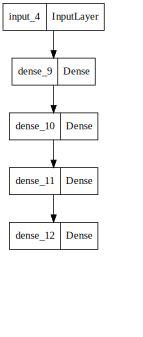

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train the network

In [ ]:
epochs = 100
batch_size = 128

In [ ]:
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Train on 955 samples, validate on 239 samples
Epoch 1/100
955/955 [==============================] - 0s 296us/sample - loss: 0.6904 - val_loss: 0.6834
Epoch 2/100
955/955 [==============================] - 0s 28us/sample - loss: 0.6699 - val_loss: 0.6365
Epoch 3/100
955/955 [==============================] - 0s 27us/sample - loss: 0.5857 - val_loss: 0.4788
Epoch 4/100
955/955 [==============================] - 0s 26us/sample - loss: 0.3650 - val_loss: 0.1878
Epoch 5/100
955/955 [==============================] - 0s 26us/sample - loss: 0.1032 - val_loss: 0.0313
Epoch 6/100
955/955 [==============================] - 0s 29us/sample - loss: 0.0229 - val_loss: 0.0197
Epoch 7/100
955/955 [==============================] - 0s 28us/sample - loss: 0.0208 - val_loss: 0.0222
Epoch 8/100
955/955 [==============================] - 0s 28us/sample - loss: 0.0229 - val_loss: 0.0233
Epoch 9/100
955/955 [==============================] - 0s 29us/sample - loss: 0.0233 - val_loss: 0.0229
Epoch 10/100
955/

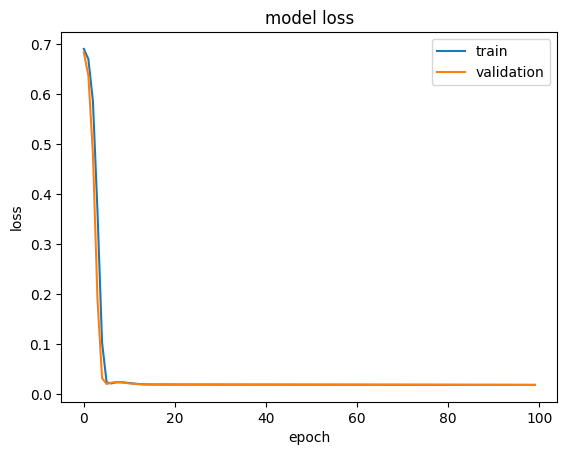

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Plot the 2D Latent representation

In [ ]:
encoder = Model(x, h)

___

# **Variational Autoencoder**

In [ ]:
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

In [ ]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [ ]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss = vae_loss)
vae.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_13 (Dense)            (None, 256)                  200960    ['input_5[0][0]']             
                                                                                                  
 dense_14 (Dense)            (None, 2)                    514       ['dense_13[0][0]']            
                                                                                                  
 dense_15 (Dense)            (None, 2)                    514       ['dense_13[0][0]']            
                                                                                            

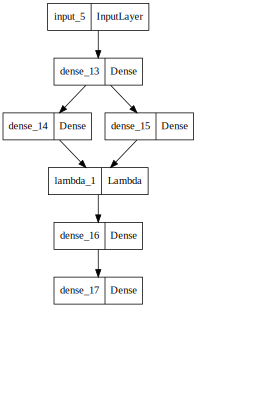

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [ ]:


history = vae.fit(X_train, X_train,shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))

Train on 955 samples, validate on 239 samples
Epoch 1/100
955/955 [==============================] - 0s 439us/sample - loss: 501.7068 - val_loss: 448.5876
Epoch 2/100
955/955 [==============================] - 0s 36us/sample - loss: 404.8528 - val_loss: 346.4955
Epoch 3/100
955/955 [==============================] - 0s 35us/sample - loss: 302.4794 - val_loss: 233.6115
Epoch 4/100
955/955 [==============================] - 0s 36us/sample - loss: 206.5275 - val_loss: 157.9610
Epoch 5/100
955/955 [==============================] - 0s 35us/sample - loss: 133.0048 - val_loss: 112.6919
Epoch 6/100
955/955 [==============================] - 0s 35us/sample - loss: 98.1484 - val_loss: 76.5356
Epoch 7/100
955/955 [==============================] - 0s 36us/sample - loss: 67.3841 - val_loss: 56.3961
Epoch 8/100
955/955 [==============================] - 0s 35us/sample - loss: 53.7344 - val_loss: 42.3283
Epoch 9/100
955/955 [==============================] - 0s 38us/sample - loss: 42.2776 - val_los

## Plot the losses

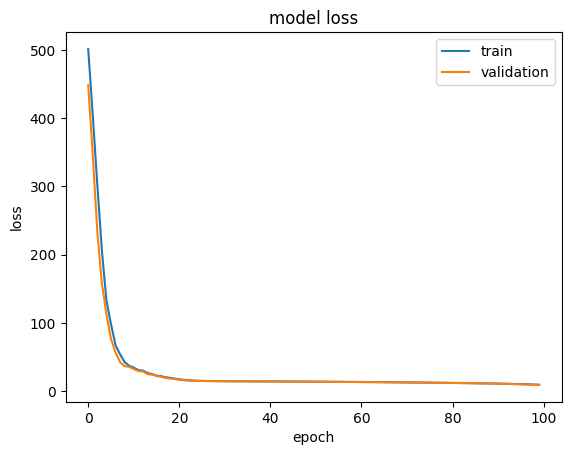

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Plot the 2D latent representation

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

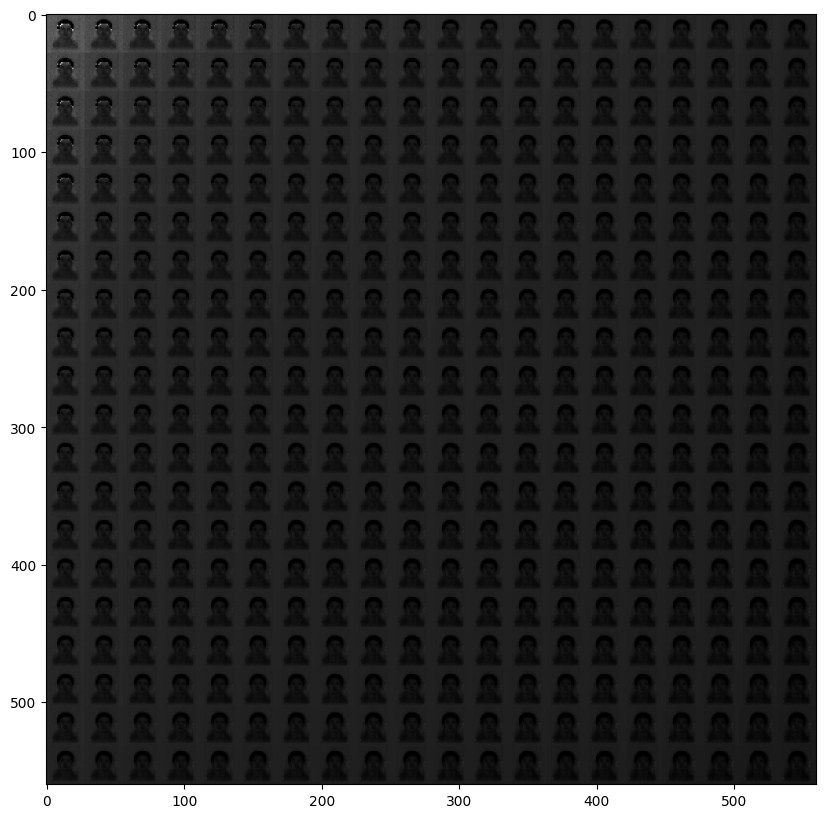

In [ ]:
# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()